# 84 Days BP Data
* GAN用の14日間分のデータを用意する: SBP,DBP,PUL (3 dim) 

In [1]:
import mojimoji
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

## Reading Data

In [2]:
df_bp = pd.read_csv(
    r'/home/hiroshi_koshimizu/work/dataset/P005_BpData_180424.csv', 
    encoding = 'shift-jis', 
    engine = 'python',
    index_col = 'Unnamed: 0'
)

## Convert String

In [3]:
df_bp['Name'] = df_bp['Name'].map(lambda string: mojimoji.zen_to_han(string))
df_bp['Name'] = df_bp['Name'].map(lambda string: string.replace('･', '/'))
df_bp['Date'] = pd.DatetimeIndex(df_bp['Date'])
df_bp['Month'] = df_bp['Date'].map(lambda date:date.month)
df_bp['Week'] = df_bp['Date'].map(lambda date:date.week)
df_bp['Time'] = df_bp['Time'].map(lambda x :pd.to_datetime(x).time())

## Delete useless colomns

In [4]:
df_bp.columns

Index(['Name', 'Birth', 'Age', 'Sex', 'Date', 'Time', 'Type', 'SBP', 'DBP',
       'PUL', 'Fit', 'Move', 'Temp', 'Irr.PUL', 'Check', 'Meas_Time', 'Month',
       'Week'],
      dtype='object')

In [5]:
df_bp = df_bp.drop(['Birth', 'Age', 'Sex', 'Fit', 'Move', 'Check', 'Irr.PUL', 'Meas_Time', 'Week', 'Month'], axis = 1)

## Extract Type

In [74]:
#血圧情報の時間単位のME判定
def ml_bpdata_mejudge(dataframe, start = [[],[]], end = [[],[]]):
    import datetime
    tmp = dataframe.copy()
    tmp['Type'] = None
    
    #Type Mを振りなおし
    flag = np.logical_and(
        tmp['Time'] >= datetime.time(start[0][0],start[0][1], start[0][2]),
        tmp['Time'] < datetime.time(end[0][0],end[0][1], end[0][2])
    )
    tmp.loc[flag, 'Type'] = 'M'
    
    #Type Eを振り直し
    flag = np.logical_or(
        tmp['Time'] >= datetime.time(start[1][0],start[1][1], start[1][2]),
        tmp['Time'] < datetime.time(end[1][0],end[1][1], end[1][2])
    )
    tmp.loc[flag, 'Type'] = 'E'
    
    tmp = tmp[np.logical_or(tmp['Type'] == 'M', tmp['Type'] == 'E')]
    
    return tmp.reset_index(drop = True)
#晩測定の時間シフト
def ml_bpdata_eshift(dataframe, e_end_time):
    import datetime
    tmp = dataframe.copy()
    flag = tmp['Time'] < datetime.time(e_end_time[0],e_end_time[1],e_end_time[2])
    tmp.loc[flag,'Date'] = tmp.loc[flag, 'Date'] - datetime.timedelta(days = 1)
    tmp['Time'] = tmp['Time'].map(lambda x:x.hour)
    tmp_time = tmp.loc[tmp['Time'] < 2, 'Time'].copy()
    #24時間異常表現
    tmp.loc[tmp['Time'] < 2, 'Time'] = tmp_time + 24
    return tmp.reset_index(drop = True)

In [75]:
test_tmp = ml_bpdata_mejudge(df_bp, start = [[4,0,0],[18,0,0]], end = [[12,0,0],[2,0,0]])
test_tmp = ml_bpdata_eshift(test_tmp, e_end_time = [2,0,0])

In [76]:
test_tmp.loc[test_tmp['Temp'] == 'LO', 'Temp'] = -1
test_tmp['Temp'] = test_tmp['Temp'].astype('float')

In [77]:
#MEデータのみする
test_e = test_tmp[test_tmp['Type']== 'E']
test_m = test_tmp[test_tmp['Type']== 'M']

In [78]:
#MEデータ抽出物
def gen_dayme_data(df, name, me_type = 'M' ):
    tmp = df[df['Name'] == name].copy().reset_index(drop = True)
    if me_type == 'M':
        df_list = map( lambda x: tmp[tmp['Date']==x][:2], tmp['Date'].unique() )
    else:
        df_list = map( lambda x: tmp[tmp['Date']==x][-2:], tmp['Date'].unique())
    return pd.concat(df_list, axis = 0)

In [79]:
#晩抽出
test_e = pd.concat(
    list(
        map( 
            lambda x : gen_dayme_data(test_e, x, me_type = 'E'), 
            test_e['Name'].unique() 
        )
    ), 
    axis = 0
)

#朝抽出
test_m = pd.concat(
    list(
        map(
            lambda x : gen_dayme_data(test_m, x, me_type = 'M'),
            test_m['Name'].unique() 
        )
    ), 
    axis = 0
)

In [104]:
#おんどなし
#test_all = pd.concat([test_e, test_m], axis = 0).drop(['Time', 'Temp'], axis = 1)
#おんどあり
test_all = pd.concat([test_e, test_m], axis = 0).drop(['Time'], axis = 1)

## Group by

In [105]:
test_all = pd.pivot_table(
    data = test_all, 
    index = ['Name','Date'],
    columns = ['Type'],
    aggfunc = np.mean
)
test_all.columns = ['_'.join(col_i) for col_i in test_all.columns]
test_all.reset_index(inplace = True)

In [106]:
def make_fill(df, name):
    tmp = df[df['Name'].isin([name])].copy()
    tmp = tmp.set_index('Date')
    tmp = tmp.resample('D').mean().fillna(method='ffill')
    tmp['Name'] = name
    return tmp

In [107]:
test_all = pd.concat(
    list(
        map(lambda x: make_fill(test_all, x), test_all['Name'].unique())
    )
).reset_index().dropna()

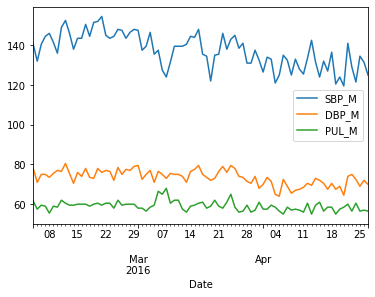

In [109]:
test_all[test_all['Name'].isin(['N/Predict 0098'])][260:344].plot(x = 'Date', y = ['SBP_M', 'DBP_M', 'PUL_M'])

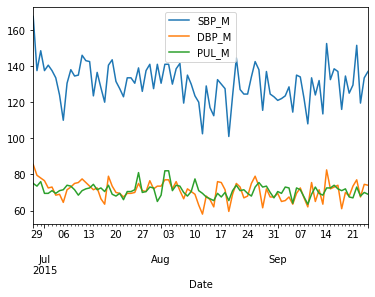

In [110]:
#test_all[test_all['Name'].isin(['N/Predict 0098'])].plot(x = 'Date', y = ['SBP_M', 'DBP_M', 'PUL_M'])
#test_all[test_all['Name'].isin(['N/Predict 0071'])][60:150].plot(x = 'Date', y = ['SBP_M', 'DBP_M', 'PUL_M'])
test_all[test_all['Name'].isin(['N/Predict 0093'])][60:150].plot(x = 'Date', y = ['SBP_M', 'DBP_M', 'PUL_M'])

In [111]:
day_param = 84
#df_bp_gr = test_all.groupby(by = ['Name','Date'], as_index = False, observed = True).mean()
df_bp_gr = test_all.set_index('Date')
#df_bp_gr = df_bp_gr.groupby(['Name'], as_index=False).resample(str(day_param)+'D', label='left').apply(list)
#df_bp_gr = df_bp_gr.reset_index(drop = True)

In [112]:
def get_timeseries(df, name, day_param, interval):
    tmp = df[df['Name'].isin([name])].resample('1D').mean().copy()
    array = []
    for inter_i in range( len(tmp) // interval ):
        array.append(tmp[inter_i*interval:day_param+inter_i*interval].T.values.flatten().tolist() + [name])
    return pd.DataFrame(array)

In [113]:
target_df = pd.concat(
    list(
        map(
            lambda x: get_timeseries(df_bp_gr, x, day_param, 28),
            df_bp_gr['Name'].unique()
        )
    )
)

In [114]:
columns = []
for col_name in df_bp_gr.columns[0:-1]:
    columns.extend([col_name + str(i+1) for i in range(day_param)])
target_df.columns = columns + ['Name']

In [115]:
target_df.dropna(inplace = True)

In [116]:
target_df.shape

(9136, 673)

## Determine labels

In [117]:
target_df['msbp'] = target_df.loc[:, 'SBP_M1':'SBP_M84'].mean(axis = 1)
target_df['mdbp'] = target_df.loc[:, 'DBP_M1':'DBP_M84'].mean(axis = 1)
target_df.reset_index(inplace = True, drop = True)

In [118]:
target_df['labels'] = 0
s_hyflag = target_df['msbp'] >= 135
target_df.loc[s_hyflag == True, 'labels'] = int(1)

d_hyflag = target_df['mdbp'] >= 85
target_df.loc[d_hyflag == True, 'labels'] = int(2)

sd_hyflag = np.logical_and( target_df['msbp'] >= 135, target_df['mdbp'] >= 85)
target_df.loc[sd_hyflag == True, 'labels'] = int(3)

sd_hyflag = target_df['msbp'] >= 150
target_df.loc[sd_hyflag == True, 'labels'] = int(4)

In [119]:
target_df['labels'].value_counts()

0    5969
1    1075
2     956
3     853
4     283
Name: labels, dtype: int64

In [120]:
target_df_arr = target_df.iloc[:, :-4].values.reshape(
    len(target_df), 
    len(target_df.iloc[:, :-4].columns) // day_param, 
    day_param
).transpose(0,2,1)

In [121]:
target_df_arr.shape

(9136, 84, 8)

## Wirte Data

In [122]:
np.savez('/home/hiroshi_koshimizu/work/RCGAN/inputs/bp_data_84_with_temp.npz',x = target_df_arr, y = target_df['labels'].values)

In [123]:
target_df['labels'].value_counts()

0    5969
1    1075
2     956
3     853
4     283
Name: labels, dtype: int64

In [124]:
target_df.loc[target_df['labels'] == 4, 'Name'].unique()

array(['N/Predict 0001', 'N/Predict 0002', 'N/Predict 0069',
       'N/Predict 0070', 'N/Predict 0071', 'N/Predict 0075',
       'N/Predict 0090', 'N/Predict 0093', 'N/Predict 0094',
       'N/Predict 0099', 'N/Predict 0152', 'N/Predict 0168',
       'N/Predict 0229', 'N/Predict 0254', 'N/Predict 0261',
       'N/Predict 0272', 'N/Predict 0278', 'N/Predict 0302',
       'N/Predict 0343', 'N/Predict 0356', 'N/Predict 0390',
       'N/Predict 0445', 'N/Predict 0452', 'N/Predict 0453',
       'N/Predict 0539', 'N/Predict 0541', 'N/Predict 0647',
       'N/Predict 0649', 'N/Predict 0657', 'N/Predict 0671',
       'N/Predict 0672', 'N/Predict 0678', 'N/Predict 0695',
       'N/Predict 0707', 'N/Predict 0823', 'N/Predict 1017',
       'N/Predict 1025', 'N/Predict 1031', 'N/Predict 1040',
       'N/Predict 1041'], dtype=object)

In [125]:
target_df_arr

array([[[76.5, 85.0, 71.5, ..., 155.5, 11.0, 13.0],
        [86.5, 90.5, 71.0, ..., 159.0, 9.0, 9.0],
        [73.0, 75.0, 65.5, ..., 122.0, 8.5, 10.0],
        ...,
        [76.0, 80.5, 71.5, ..., 140.0, 20.0, 19.0],
        [76.0, 84.5, 71.5, ..., 143.5, 20.0, 19.0],
        [71.0, 77.5, 70.5, ..., 136.0, 20.0, 21.0]],

       [[78.0, 77.5, 69.0, ..., 144.5, 13.0, 14.0],
        [78.5, 80.0, 66.0, ..., 152.5, 11.0, 13.0],
        [78.5, 89.0, 71.0, ..., 173.0, 12.0, 11.0],
        ...,
        [71.0, 76.5, 67.5, ..., 129.0, 27.0, 24.0],
        [73.0, 75.0, 64.5, ..., 125.0, 26.0, 24.0],
        [73.5, 74.0, 63.0, ..., 123.0, 25.0, 25.0]],

       [[70.0, 82.0, 66.0, ..., 146.5, 15.0, 13.0],
        [78.0, 75.5, 66.0, ..., 146.0, 15.0, 13.0],
        [75.0, 78.5, 71.5, ..., 154.5, 18.0, 13.0],
        ...,
        [75.0, 73.0, 63.5, ..., 128.0, 26.0, 27.0],
        [75.5, 75.5, 69.0, ..., 140.0, 29.0, 24.0],
        [68.0, 77.0, 66.0, ..., 128.5, 27.0, 26.0]],

       ...,

       [[